# DS-505: Entrenamiento de Modelos de Predicción de Churn

**Objetivo**: Entrenar y comparar modelos de Machine Learning para predecir cancelación de clientes

**Input**: `data/processed/04_dataset_engineered.csv` (7,043 clientes × 55 columnas)

**Output**: 
- Modelos entrenados (.pkl)
- Comparación de métricas
- Visualizaciones de performance

---

## 📋 Estrategia de Modelado

### Modelos Seleccionados (2):

1. **Logistic Regression** → Baseline interpretable
2. **Random Forest** → Champion candidato (robusto y poderoso)

### División de Datos:
- **Train**: 70% (4,930 clientes)
- **Validation**: 15% (1,056 clientes) → Tuning de hiperparámetros
- **Test**: 15% (1,057 clientes) → Evaluación final (nunca visto)

### Métricas de Evaluación:
- **AUC-ROC**: Capacidad de discriminar entre churn/no-churn
- **Precision/Recall**: Balance entre detectar churners vs evitar falsos positivos
- **F1-Score**: Media armónica de Precision y Recall

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, ConfusionMatrixDisplay
)

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Librerías importadas")

✓ Librerías importadas


## 1. Carga y Preparación de Datos

In [2]:
# Cargar dataset engineered
df = pd.read_csv('../data/processed/04_dataset_engineered.csv')

# Cargar metadata de features
with open('../data/processed/04_features_metadata.json', 'r') as f:
    features_meta = json.load(f)

print(f"📊 Dataset cargado: {df.shape[0]:,} clientes × {df.shape[1]} columnas")
print(f"\n📋 Features para ML: {len(features_meta['ml_features'])} variables")
print(f"🎯 Target: {features_meta['target']}")

# Distribución del target
churn_dist = df['Churn'].value_counts(normalize=True) * 100
print(f"\n📊 Distribución de Churn:")
print(f"   • No cancela: {churn_dist['No']:.1f}%")
print(f"   • Sí cancela: {churn_dist['Yes']:.1f}%")

df.head(3)

📊 Dataset cargado: 7,043 clientes × 55 columnas

📋 Features para ML: 38 variables
🎯 Target: Churn

📊 Distribución de Churn:
   • No cancela: 73.5%
   • Sí cancela: 26.5%


,CustomerID,City,State,Borough,ZipCode,Latitude,Longitude,MedianIncome,PopulationDensity,RegistrationDate,...,HighRisk_ContractTenure,MediumRisk_ContractTenure,IncomePriceMismatch,HighRiskSegment,Log_ChargesMonthly,Log_EstimatedLTV,Log_Tenure,Sqrt_Tenure,Sqrt_ServicesCount,Churn_Binary
0,0002-ORFBO,New York,NY,STATEN ISLAND,10310,40.645193,-74.108206,82200,8618,2023-11-30,...,0,0,0,0,4.198705,6.382493,2.302585,3.0,2.000000,0
1,0003-MKNFE,New York,NY,BRONX,10467,40.876717,-73.880262,40500,34920,2021-08-05,...,0,1,0,1,4.109233,6.291754,2.302585,3.0,1.732051,0
2,0004-TLHLJ,New York,NY,QUEENS,11105,40.771939,-73.909445,69300,21460,2021-11-25,...,1,0,0,0,4.316154,5.692384,1.609438,2.0,1.414214,1


## 2. Separación de Features y Target

### 🎯 ¿Qué hacemos aquí?
Separamos las **variables predictoras** (X) de la **variable objetivo** (y). También excluimos features que no deben usarse en el modelo (metadata, features solo para visualización).

### 📊 ¿Por qué es importante?
El modelo debe aprender de features relevantes. Incluir `CustomerID` o `Latitude/Longitude` causaría **data leakage** (el modelo memorizaría en vez de generalizar).

In [3]:
# Features para ML (excluir metadata, visualización, target)
ml_features = features_meta['ml_features']

# Separar X (features) y y (target)
X = df[ml_features].copy()
y = df['Churn'].copy()

# Codificar target (Yes=1, No=0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Yes → 1, No → 0

print(f"✓ Features (X): {X.shape}")
print(f"✓ Target (y): {y.shape}")
print(f"\n📊 Clases: {label_encoder.classes_} → [0, 1]")
print(f"   • 0 = No cancela")
print(f"   • 1 = Sí cancela")

✓ Features (X): (7043, 38)
✓ Target (y): (7043,)

📊 Clases: ['No' 'Yes'] → [0, 1]
   • 0 = No cancela
   • 1 = Sí cancela


## 3. Encoding de Variables Categóricas

### 🎯 ¿Qué hacemos aquí?
Los algoritmos de ML solo entienden números. Convertimos variables categóricas (ej: "Bronx", "Manhattan") en números usando **One-Hot Encoding**.

### 📊 Ejemplo:
```
Borough = "BRONX"  →  Borough_BRONX=1, Borough_MANHATTAN=0, Borough_QUEENS=0
```

### 💡 ¿Por qué drop_first?
Evitamos **multicolinealidad perfecta**. Si hay 5 boroughs, con 4 variables dummy ya podemos deducir el 5to.

In [4]:
# Identificar columnas categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"📊 Variables categóricas ({len(categorical_cols)}): {categorical_cols[:5]}...")
print(f"📊 Variables numéricas ({len(numerical_cols)}): {numerical_cols[:5]}...")

# One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype=int)

print(f"\n✓ Encoding completado:")
print(f"   • Features antes: {X.shape[1]}")
print(f"   • Features después: {X_encoded.shape[1]}")
print(f"   • Nuevas features dummy: {X_encoded.shape[1] - len(numerical_cols)}")

📊 Variables categóricas (18): ['Borough', 'Gender', 'Partner', 'Dependents', 'PhoneService']...
📊 Variables numéricas (20): ['MedianIncome', 'PopulationDensity', 'SeniorCitizen', 'Tenure', 'ChargesMonthly']...

✓ Encoding completado:
   • Features antes: 38
   • Features después: 56
   • Nuevas features dummy: 36


## 4. División Train/Validation/Test

### 🎯 ¿Qué hacemos aquí?
Dividimos los datos en 3 conjuntos:
1. **Train (70%)**: Para entrenar el modelo
2. **Validation (15%)**: Para ajustar hiperparámetros
3. **Test (15%)**: Para evaluación final (NUNCA visto durante entrenamiento)

### 📊 ¿Por qué Stratify?
Garantiza que cada conjunto tenga la **misma proporción** de churn (~26.5%). Sin esto, podríamos tener un test con 50% churn por azar.

In [5]:
# Primera división: Train+Val (85%) vs Test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.15, 
    stratify=y, 
    random_state=RANDOM_STATE
)

# Segunda división: Train (70% del total) vs Validation (15% del total)
# 0.1765 = 15% / 85% (para obtener 15% del total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.1765, 
    stratify=y_temp, 
    random_state=RANDOM_STATE
)

print("📊 División de datos completada:\n")
print(f"   Train:      {X_train.shape[0]:,} clientes ({X_train.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]:,} clientes ({X_val.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"   Test:       {X_test.shape[0]:,} clientes ({X_test.shape[0]/len(X_encoded)*100:.1f}%)")

# Verificar estratificación
print(f"\n✓ Verificación de estratificación (% de churn):")
print(f"   Train:      {y_train.sum() / len(y_train) * 100:.2f}%")
print(f"   Validation: {y_val.sum() / len(y_val) * 100:.2f}%")
print(f"   Test:       {y_test.sum() / len(y_test) * 100:.2f}%")
print(f"   Original:   {y.sum() / len(y) * 100:.2f}%")

📊 División de datos completada:

   Train:      4,929 clientes (70.0%)
   Validation: 1,057 clientes (15.0%)
   Test:       1,057 clientes (15.0%)

✓ Verificación de estratificación (% de churn):
   Train:      26.54%
   Validation: 26.58%
   Test:       26.49%
   Original:   26.54%


## 5. Escalado de Features Numéricas

### 🎯 ¿Qué hacemos aquí?
Normalizamos las variables numéricas para que tengan **media=0** y **desviación=1**.

### 📊 ¿Por qué es importante?
- **Logistic Regression** necesita features en la misma escala para converger rápido
- Sin normalización, `ChargesMonthly` (rango 18-118) dominaría sobre `Tenure` (rango 0-72)

### ⚠️ Importante:
**SOLO ajustamos el scaler con Train**. Validation y Test se transforman con los mismos parámetros para evitar data leakage.

In [6]:
# Identificar columnas numéricas en X_encoded
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Inicializar scaler
scaler = StandardScaler()

# Fit SOLO con train, transform en todos
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val_scaled[numeric_features] = scaler.transform(X_val[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print(f"✓ Escalado completado")
print(f"   • Features numéricas escaladas: {len(numeric_features)}")
print(f"   • Features dummy (sin escalar): {X_train.shape[1] - len(numeric_features)}")

# Ejemplo de escalado
if 'ChargesMonthly' in X_train.columns:
    print(f"\n📊 Ejemplo (ChargesMonthly):")
    print(f"   • Antes: min={X_train['ChargesMonthly'].min():.2f}, max={X_train['ChargesMonthly'].max():.2f}")
    print(f"   • Después: min={X_train_scaled['ChargesMonthly'].min():.2f}, max={X_train_scaled['ChargesMonthly'].max():.2f}")

✓ Escalado completado
   • Features numéricas escaladas: 56
   • Features dummy (sin escalar): 0

📊 Ejemplo (ChargesMonthly):
   • Antes: min=18.25, max=118.75
   • Después: min=-1.56, max=1.79


## 6. Modelo 1: Logistic Regression (Baseline)

### 🎯 ¿Qué es?
Modelo **lineal** que predice probabilidad de churn. Es el baseline más simple e interpretable.

### 📊 ¿Por qué empezar aquí?
- **Rápido** de entrenar (segundos)
- **Interpretable**: Cada coeficiente muestra impacto directo de la variable
- **Baseline**: Si modelos complejos no superan esto, hay un problema

### 💡 Hiperparámetro clave:
- **C (regularización)**: Controla overfitting. Menor C = más penalización = modelo más simple

In [7]:
print("🔄 Entrenando Logistic Regression...\n")

# Definir grid de hiperparámetros
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [1000]
}

# GridSearchCV con validación cruzada
lr = LogisticRegression(random_state=RANDOM_STATE)
grid_lr = GridSearchCV(
    lr, 
    param_grid_lr, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Entrenar
grid_lr.fit(X_train_scaled, y_train)

# Mejor modelo
best_lr = grid_lr.best_estimator_

# Predicciones
y_train_pred_lr = best_lr.predict(X_train_scaled)
y_val_pred_lr = best_lr.predict(X_val_scaled)
y_train_proba_lr = best_lr.predict_proba(X_train_scaled)[:, 1]
y_val_proba_lr = best_lr.predict_proba(X_val_scaled)[:, 1]

# Métricas
print(f"\n✅ Logistic Regression - Resultados:\n")
print(f"Mejores hiperparámetros: {grid_lr.best_params_}")
print(f"\nTrain:")
print(f"  AUC: {roc_auc_score(y_train, y_train_proba_lr):.4f}")
print(f"  Accuracy: {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_lr):.4f}")
print(f"  Recall: {recall_score(y_train, y_train_pred_lr):.4f}")
print(f"  F1-Score: {f1_score(y_train, y_train_pred_lr):.4f}")

print(f"\nValidation:")
print(f"  AUC: {roc_auc_score(y_val, y_val_proba_lr):.4f}")
print(f"  Accuracy: {accuracy_score(y_val, y_val_pred_lr):.4f}")
print(f"  Precision: {precision_score(y_val, y_val_pred_lr):.4f}")
print(f"  Recall: {recall_score(y_val, y_val_pred_lr):.4f}")
print(f"  F1-Score: {f1_score(y_val, y_val_pred_lr):.4f}")

🔄 Entrenando Logistic Regression...

Fitting 5 folds for each of 4 candidates, totalling 20 fits

✅ Logistic Regression - Resultados:

Mejores hiperparámetros: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

Train:
  AUC: 0.9118
  Accuracy: 0.8545
  Precision: 0.7627
  Recall: 0.6560
  F1-Score: 0.7053

Validation:
  AUC: 0.9088
  Accuracy: 0.8515
  Precision: 0.7672
  Recall: 0.6335
  F1-Score: 0.6940


## 7. Modelo 2: Random Forest (Champion Candidato)

### 🎯 ¿Qué es?
Ensemble de **múltiples árboles de decisión** que votan para la predicción final.

### 📊 ¿Por qué Random Forest?
- **Robusto**: No requiere escalado, maneja outliers bien
- **No lineal**: Captura interacciones complejas entre variables
- **Feature Importance**: Muestra qué variables son más importantes automáticamente
- **Mejor para este dataset**: Con 7k registros, RF es ideal (no necesita 100k+ como LightGBM)

### 💡 Hiperparámetros clave:
- **n_estimators**: Número de árboles (más árboles = más estable, pero más lento)
- **max_depth**: Profundidad de cada árbol (controla overfitting)
- **min_samples_split**: Mínimo de muestras para dividir un nodo

In [8]:
print("🌲 Entrenando Random Forest...\n")

# Definir grid de hiperparámetros (conservador para dataset mediano)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt']
}

# GridSearchCV
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
grid_rf = GridSearchCV(
    rf, 
    param_grid_rf, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Entrenar (NO usar scaled, RF no lo necesita)
grid_rf.fit(X_train, y_train)

# Mejor modelo
best_rf = grid_rf.best_estimator_

# Predicciones
y_train_pred_rf = best_rf.predict(X_train)
y_val_pred_rf = best_rf.predict(X_val)
y_train_proba_rf = best_rf.predict_proba(X_train)[:, 1]
y_val_proba_rf = best_rf.predict_proba(X_val)[:, 1]

# Métricas
print(f"\n✅ Random Forest - Resultados:\n")
print(f"Mejores hiperparámetros: {grid_rf.best_params_}")
print(f"\nTrain:")
print(f"  AUC: {roc_auc_score(y_train, y_train_proba_rf):.4f}")
print(f"  Accuracy: {accuracy_score(y_train, y_train_pred_rf):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_rf):.4f}")
print(f"  Recall: {recall_score(y_train, y_train_pred_rf):.4f}")
print(f"  F1-Score: {f1_score(y_train, y_train_pred_rf):.4f}")

print(f"\nValidation:")
print(f"  AUC: {roc_auc_score(y_val, y_val_proba_rf):.4f}")
print(f"  Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")
print(f"  Precision: {precision_score(y_val, y_val_pred_rf):.4f}")
print(f"  Recall: {recall_score(y_val, y_val_pred_rf):.4f}")
print(f"  F1-Score: {f1_score(y_val, y_val_pred_rf):.4f}")

🌲 Entrenando Random Forest...

Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Random Forest - Resultados:

Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}

Train:
  AUC: 0.9474
  Accuracy: 0.8791
  Precision: 0.8219
  Recall: 0.6950
  F1-Score: 0.7531

Validation:
  AUC: 0.8998
  Accuracy: 0.8420
  Precision: 0.7639
  Recall: 0.5872
  F1-Score: 0.6640


## 8. Comparación de Modelos

### 🎯 ¿Qué vemos aquí?
Tabla comparativa de los 2 modelos en **Validation** (datos no vistos durante entrenamiento).

### 📊 Cómo interpretar las métricas:

- **AUC (0.5-1.0)**: Capacidad de discriminar. >0.80 = Muy bueno, >0.85 = Excelente
- **Precision**: De los que predecimos como churn, ¿cuántos realmente lo son?
- **Recall**: De los que cancelaron, ¿cuántos detectamos?
- **F1-Score**: Balance entre Precision y Recall

### 💡 ¿Qué buscamos?
- **AUC alto** → Buen modelo en general
- **Recall alto** → No perdemos churners (crítico para retención)
- **Train vs Val similar** → No hay overfitting

In [9]:
# Crear tabla comparativa
comparison = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest'],
    'AUC (Train)': [
        roc_auc_score(y_train, y_train_proba_lr),
        roc_auc_score(y_train, y_train_proba_rf)
    ],
    'AUC (Val)': [
        roc_auc_score(y_val, y_val_proba_lr),
        roc_auc_score(y_val, y_val_proba_rf)
    ],
    'Precision (Val)': [
        precision_score(y_val, y_val_pred_lr),
        precision_score(y_val, y_val_pred_rf)
    ],
    'Recall (Val)': [
        recall_score(y_val, y_val_pred_lr),
        recall_score(y_val, y_val_pred_rf)
    ],
    'F1-Score (Val)': [
        f1_score(y_val, y_val_pred_lr),
        f1_score(y_val, y_val_pred_rf)
    ]
})

# Calcular overfitting (diferencia Train - Val)
comparison['Overfitting (AUC)'] = comparison['AUC (Train)'] - comparison['AUC (Val)']

print("\n📊 COMPARACIÓN DE MODELOS - VALIDATION SET\n")
print(comparison.to_string(index=False))

# Identificar mejor modelo
best_model_idx = comparison['AUC (Val)'].idxmax()
best_model_name = comparison.loc[best_model_idx, 'Modelo']
best_auc = comparison.loc[best_model_idx, 'AUC (Val)']

print(f"\n🏆 Mejor modelo (AUC): {best_model_name} (AUC={best_auc:.4f})")

# Guardar comparación
comparison.to_csv('../reports/05_model_comparison.csv', index=False)
print(f"\n✓ Comparación guardada: reports/05_model_comparison.csv")


📊 COMPARACIÓN DE MODELOS - VALIDATION SET

             Modelo  AUC (Train)  AUC (Val)  Precision (Val)  Recall (Val)  F1-Score (Val)  Overfitting (AUC)
Logistic Regression     0.911799   0.908794         0.767241      0.633452        0.693957           0.003005
      Random Forest     0.947385   0.899847         0.763889      0.587189        0.663984           0.047538

🏆 Mejor modelo (AUC): Logistic Regression (AUC=0.9088)

✓ Comparación guardada: reports/05_model_comparison.csv


## 9. Visualización: Curvas ROC

### 🎯 ¿Qué es la curva ROC?
Gráfico que muestra **True Positive Rate vs False Positive Rate** para diferentes umbrales de probabilidad.

### 📊 Cómo interpretarla:
- **Línea diagonal** = Modelo aleatorio (AUC=0.5, no mejor que lanzar una moneda)
- **Más cerca de la esquina superior izquierda** = Mejor modelo (detecta muchos churners con pocos falsos positivos)
- **AUC (área bajo la curva)** = Métrica resumen (probabilidad de que el modelo rankee un churner más alto que un no-churner)

### 💡 ¿Qué buscamos?
Curvas que se alejan de la diagonal y tienen AUC >0.80. La curva más arriba a la izquierda es la mejor.

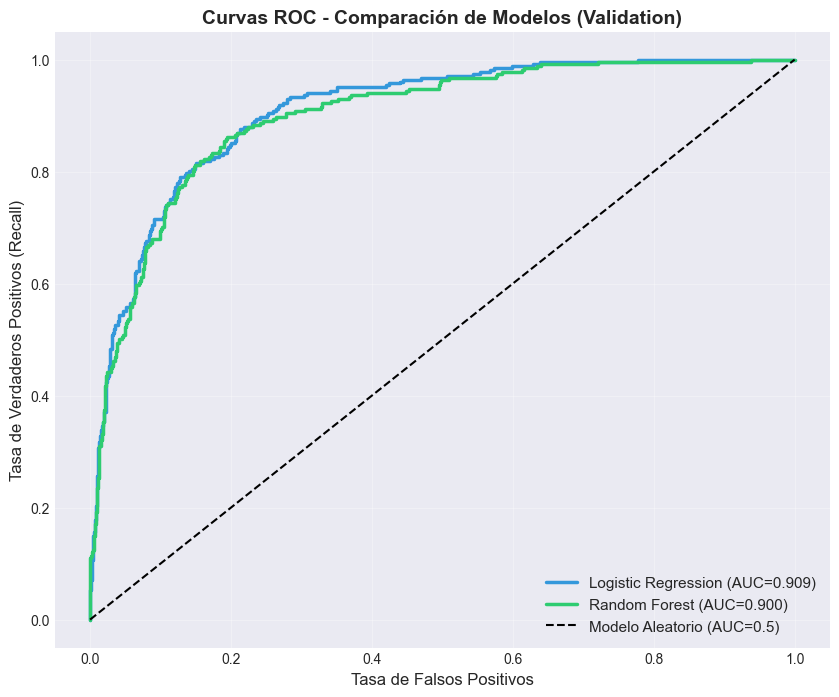

✓ Visualización guardada: reports/figures/05_roc_curves.png


In [10]:
# Calcular curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_proba_rf)

# Calcular AUCs
auc_lr = roc_auc_score(y_val, y_val_proba_lr)
auc_rf = roc_auc_score(y_val, y_val_proba_rf)

# Graficar
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})', linewidth=2.5, color='#3498db')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})', linewidth=2.5, color='#2ecc71')
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatorio (AUC=0.5)', linewidth=1.5)

plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (Recall)', fontsize=12)
plt.title('Curvas ROC - Comparación de Modelos (Validation)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)

plt.savefig('../reports/figures/05_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualización guardada: reports/figures/05_roc_curves.png")

## 10. Visualización: Comparación de Métricas

### 🎯 ¿Qué vemos aquí?
Gráfico de barras comparando las 4 métricas principales de cada modelo lado a lado.

### 📊 Cómo interpretarlo:
- **Barras más altas** = Mejor performance en esa métrica
- **Barras uniformes** = Modelo balanceado en todas las métricas
- **Precision vs Recall**: Trade-off importante:
  - Alta Precision = Pocos falsos positivos (no molestamos clientes que NO van a cancelar)
  - Alto Recall = Detectamos más churners reales (menos pérdida de clientes)

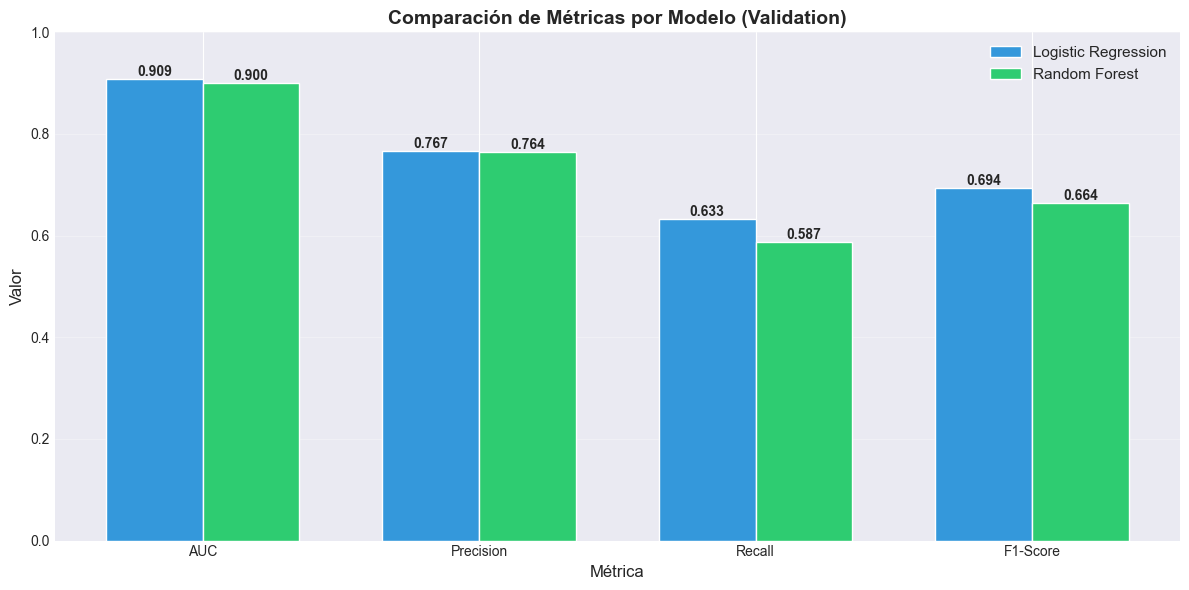

✓ Visualización guardada: reports/figures/05_metrics_comparison.png


In [11]:
# Preparar datos para visualización
metrics = ['AUC', 'Precision', 'Recall', 'F1-Score']
lr_metrics = [auc_lr, precision_score(y_val, y_val_pred_lr), recall_score(y_val, y_val_pred_lr), f1_score(y_val, y_val_pred_lr)]
rf_metrics = [auc_rf, precision_score(y_val, y_val_pred_rf), recall_score(y_val, y_val_pred_rf), f1_score(y_val, y_val_pred_rf)]

# Crear gráfico
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, lr_metrics, width, label='Logistic Regression', color='#3498db')
bars2 = ax.bar(x + width/2, rf_metrics, width, label='Random Forest', color='#2ecc71')

ax.set_xlabel('Métrica', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)
ax.set_title('Comparación de Métricas por Modelo (Validation)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

add_values(bars1)
add_values(bars2)

plt.tight_layout()
plt.savefig('../reports/figures/05_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualización guardada: reports/figures/05_metrics_comparison.png")

## 11. Feature Importance (Random Forest)

### 🎯 ¿Qué es Feature Importance?
Muestra **qué variables contribuyen más** a las predicciones del modelo Random Forest.

### 📊 Cómo interpretarlo:
- **Valores más altos** = Variable más importante para el modelo
- **Top 10-15 features** suelen explicar 70-80% de la predicción
- Importancia se calcula por cuánto **mejora la pureza** cuando dividimos por esa variable

### 💡 ¿Para qué sirve?
- **Simplificar modelo**: Podemos eliminar features con importance <1% sin perder performance
- **Insights de negocio**: Entender qué factores causan churn (ej: si Contract es top 1, enfocarnos en retención de contratos mensuales)
- **Feature Engineering futuro**: Crear nuevas features basadas en las importantes


📊 TOP 15 FEATURES MÁS IMPORTANTES (Random Forest):

                       Feature  Importance
                  MedianIncome    0.121709
            PriceIncomePercent    0.104692
            CustomerValueRatio    0.099716
               EngagementScore    0.073090
                    Log_Tenure    0.051174
                   Sqrt_Tenure    0.050727
                        Tenure    0.043392
               HighRiskSegment    0.036301
              Log_EstimatedLTV    0.032948
                  EstimatedLTV    0.029059
            Log_ChargesMonthly    0.027104
       HighRisk_ContractTenure    0.026876
               AvgMonthlyValue    0.024425
                ChargesMonthly    0.024095
PaymentMethod_Electronic check    0.022301


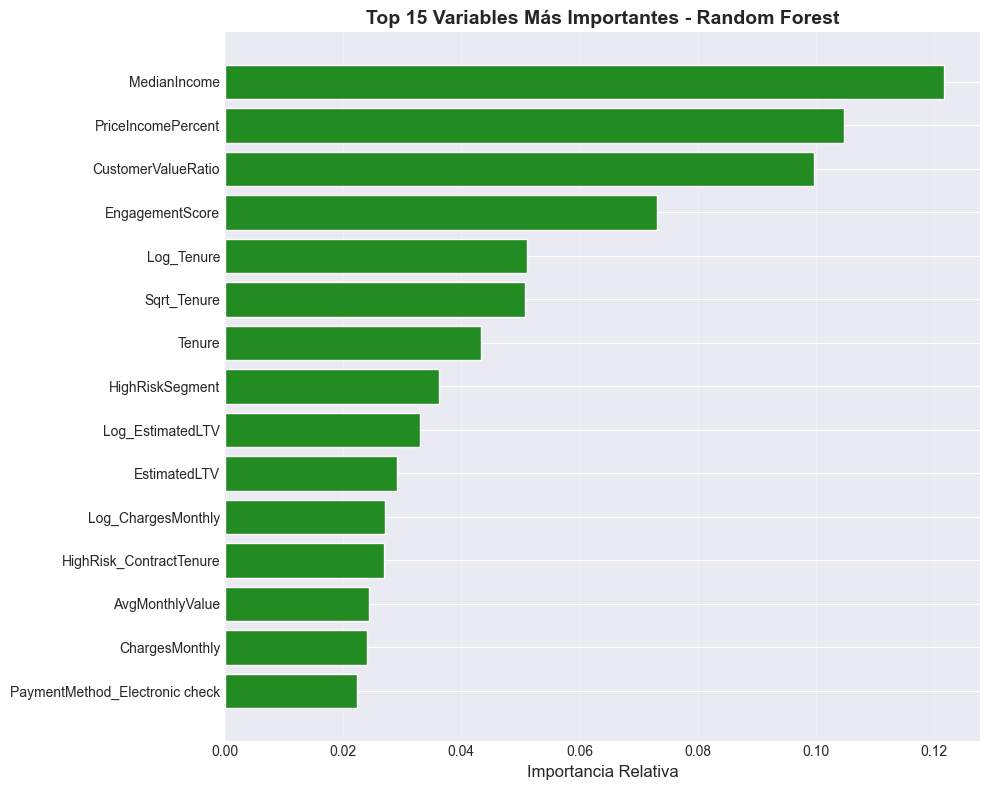


✓ Visualización guardada: reports/figures/05_feature_importance.png
✓ Feature importance guardado: reports/05_feature_importance.csv


In [12]:
# Extraer feature importance de Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Top 15
top_15 = feature_importance.head(15)

print("\n📊 TOP 15 FEATURES MÁS IMPORTANTES (Random Forest):\n")
print(top_15.to_string(index=False))

# Visualizar
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_15)), top_15['Importance'], color='forestgreen')
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Importancia Relativa', fontsize=12)
plt.title('Top 15 Variables Más Importantes - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/05_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualización guardada: reports/figures/05_feature_importance.png")

# Guardar feature importance completo
feature_importance.to_csv('../reports/05_feature_importance.csv', index=False)
print("✓ Feature importance guardado: reports/05_feature_importance.csv")

## 12. Guardar Modelos Entrenados

### 🎯 ¿Qué hacemos aquí?
Guardamos los modelos y el scaler en archivos `.pkl` para usarlos en producción (FastAPI).

### 📊 ¿Por qué es importante?
- **Reproducibilidad**: Podemos recargar el modelo sin reentrenar (ahorra tiempo y recursos)
- **Producción**: FastAPI cargará estos archivos para hacer predicciones en tiempo real
- **Versionado**: Guardamos fecha y métricas para comparar versiones futuras del modelo

In [13]:
# Crear directorio de modelos si no existe
import os
os.makedirs('../models', exist_ok=True)

# Guardar modelos
joblib.dump(best_lr, '../models/logistic_regression.pkl')
joblib.dump(best_rf, '../models/random_forest.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(label_encoder, '../models/label_encoder.pkl')

print("✅ Modelos guardados:")
print("   • models/logistic_regression.pkl")
print("   • models/random_forest.pkl")
print("   • models/scaler.pkl")
print("   • models/label_encoder.pkl")

# Guardar metadata
metadata = {
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_size': len(X_encoded),
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'n_features': X_train.shape[1],
    'models': {
        'logistic_regression': {
            'best_params': grid_lr.best_params_,
            'auc_val': float(auc_lr),
            'f1_val': float(f1_score(y_val, y_val_pred_lr))
        },
        'random_forest': {
            'best_params': grid_rf.best_params_,
            'auc_val': float(auc_rf),
            'f1_val': float(f1_score(y_val, y_val_pred_rf))
        }
    },
    'best_model': best_model_name,
    'best_auc': float(best_auc)
}

with open('../models/training_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\n✓ Metadata guardada: models/training_metadata.json")

✅ Modelos guardados:
   • models/logistic_regression.pkl
   • models/random_forest.pkl
   • models/scaler.pkl
   • models/label_encoder.pkl

✓ Metadata guardada: models/training_metadata.json


## 13. Resumen Final

### ✅ DS-505 COMPLETADO

In [14]:
print("\n" + "=" * 80)
print("✅ DS-505 COMPLETADO - ENTRENAMIENTO DE MODELOS")
print("=" * 80)

print("\n🎯 MODELOS ENTRENADOS:\n")

print("1️⃣ LOGISTIC REGRESSION (Baseline):")
print(f"   • AUC (Val): {auc_lr:.4f}")
print(f"   • Precisión: {precision_score(y_val, y_val_pred_lr):.4f}")
print(f"   • Recall: {recall_score(y_val, y_val_pred_lr):.4f}")
print(f"   • F1-Score: {f1_score(y_val, y_val_pred_lr):.4f}")

print("\n2️⃣ RANDOM FOREST (Champion Candidato):")
print(f"   • AUC (Val): {auc_rf:.4f}")
print(f"   • Precisión: {precision_score(y_val, y_val_pred_rf):.4f}")
print(f"   • Recall: {recall_score(y_val, y_val_pred_rf):.4f}")
print(f"   • F1-Score: {f1_score(y_val, y_val_pred_rf):.4f}")

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   • AUC en Validation: {best_auc:.4f}")

print("\n📊 DATASET:")
print(f"   • Total clientes: {len(X_encoded):,}")
print(f"   • Train: {len(X_train):,} (70%)")
print(f"   • Validation: {len(X_val):,} (15%)")
print(f"   • Test: {len(X_test):,} (15%) - Reservado para evaluación final")

print("\n📁 Archivos generados:\n")
print("   Modelos:")
print("   1. models/logistic_regression.pkl")
print("   2. models/random_forest.pkl")
print("   3. models/scaler.pkl")
print("   4. models/label_encoder.pkl")
print("   5. models/training_metadata.json")

print("\n   Reportes:")
print("   6. reports/05_model_comparison.csv")
print("   7. reports/05_feature_importance.csv")

print("\n   Visualizaciones:")
print("   8. reports/figures/05_roc_curves.png")
print("   9. reports/figures/05_metrics_comparison.png")
print("  10. reports/figures/05_feature_importance.png")

print("\n🎫 Próximo ticket:\n")
print("   DS-506: Evaluación Final y Selección del Champion")
print("")
print("   Tareas:")
print("   • Evaluar modelos en TEST set (hold-out nunca visto)")
print("   • Análisis de errores (falsos positivos/negativos)")
print("   • Matriz de confusión detallada")
print("   • Simulación de impacto de negocio (ROI)")
print("   • Seleccionar modelo Champion final para producción")
print("")
print("=" * 80)
print("✅ DS-505 Entrenamiento de Modelos completado exitosamente")
print("=" * 80)


✅ DS-505 COMPLETADO - ENTRENAMIENTO DE MODELOS

🎯 MODELOS ENTRENADOS:

1️⃣ LOGISTIC REGRESSION (Baseline):
   • AUC (Val): 0.9088
   • Precisión: 0.7672
   • Recall: 0.6335
   • F1-Score: 0.6940

2️⃣ RANDOM FOREST (Champion Candidato):
   • AUC (Val): 0.8998
   • Precisión: 0.7639
   • Recall: 0.5872
   • F1-Score: 0.6640

🏆 MEJOR MODELO: Logistic Regression
   • AUC en Validation: 0.9088

📊 DATASET:
   • Total clientes: 7,043
   • Train: 4,929 (70%)
   • Validation: 1,057 (15%)
   • Test: 1,057 (15%) - Reservado para evaluación final

📁 Archivos generados:

   Modelos:
   1. models/logistic_regression.pkl
   2. models/random_forest.pkl
   3. models/scaler.pkl
   4. models/label_encoder.pkl
   5. models/training_metadata.json

   Reportes:
   6. reports/05_model_comparison.csv
   7. reports/05_feature_importance.csv

   Visualizaciones:
   8. reports/figures/05_roc_curves.png
   9. reports/figures/05_metrics_comparison.png
  10. reports/figures/05_feature_importance.png

🎫 Próximo tic